In [1]:
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
%matplotlib inline

def plot_clusters(samples, md, ax):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    idx = md['Cluster'] == 'Cluster 1'
    ax.scatter(samples.loc[idx, 'PC1'], samples.loc[idx, 'PC2'], label='Cluster 1')   
    ax.scatter(samples.loc[~idx, 'PC1'], samples.loc[~idx, 'PC2'], label='Cluster 2')    
    
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2', fontsize=18)    
    ax.set_xlabel('PC1', fontsize=18)
    return ax

In [2]:

#simulation view
simulation=pd.read_csv('cluster_models/simulation_subsampled_noisy.csv', index_col=[0,1,2,3])
model_100=simulation.loc[(2,20,100,),:]
model_10000=simulation.loc[(2,20,2000,),:]


#import a few ordinations to plot
clust=['2_20_100_PCA','2_20_100_RPCA',
     '2_20_10000_PCA','2_20_10000_RPCA']
clustord=pd.concat({tuple(x.split('_')):pd.read_csv('cluster_models/ordination/'+x+'.csv',
                                                   index_col=0) for x in clust},axis=0)[['PC1','PC2']]
rank='2'
clustord_1000_PCA=clustord.loc[(rank,'20','100','PCA'),:]
clustord_1000_RPCA=clustord.loc[(rank,'20','100','RPCA'),:]
clustord_10000_PCA=clustord.loc[(rank,'20','10000','PCA'),:]
clustord_10000_RPCA=clustord.loc[(rank,'20','10000','RPCA'),:]
clustmap={**{'sample_'+str(x):['Cluster 1'] for x in range(int(clustord_1000_PCA.shape[0]/int(rank)))},
        **{'sample_'+str(x):['Cluster 2'] for x in range(int(clustord_1000_PCA.shape[0]/int(rank))
                                                      ,int(clustord_1000_PCA.shape[0]))}}
clustmap=pd.DataFrame(clustmap,index=['Cluster']).T

#import and view results from simuilation
cluster_results=pd.read_csv('cluster_models/results.csv')
processing={2:'Preprocessed',1:'Unprocessed'}
cluster_results['Proc']=[processing[len(x.split('rclr'))] for x in cluster_results.Method]
cluster_results['Method_']=[x.replace('rclr-','') for x in cluster_results.Method]
cluster_results_plot=cluster_results[cluster_results.Overlap.isin([20])]
cluster_results_plot=cluster_results_plot[cluster_results_plot.Method_.isin(['OptSpace'])]


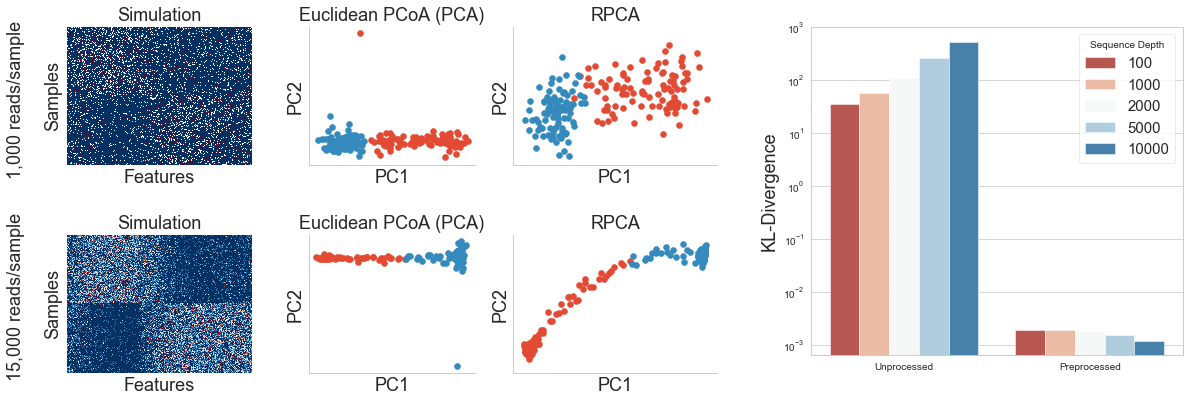

In [5]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker

plt.style.use('ggplot')
sns.set_style('whitegrid')

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(20, 7), facecolor='white')
gs = gridspec.GridSpec(110, 300)

ax1=plt.subplot(gs[5:45, :50])
ax2=plt.subplot(gs[65:105, :50])

sns.heatmap(model_100.as_matrix(),robust=True
            , xticklabels=False, yticklabels=False,
           cbar=False,cmap='RdBu_r',ax=ax1)
sns.heatmap(model_10000,robust=True
            , xticklabels=False, yticklabels=False,
           cbar=False,cmap='RdBu_r',ax=ax2)

ax1.set_xlabel('Features',fontsize=18)
ax1.set_ylabel('Samples',fontsize=18)
ax1.set_title('Simulation',fontsize=18)
ax2.set_xlabel('Features',fontsize=18)
ax2.set_ylabel('Samples',fontsize=18)
ax2.set_title('Simulation',fontsize=18)

ax3=plt.subplot(gs[5:45, 65:110])
ax4=plt.subplot(gs[65:105, 65:110])
ax3.set_title('Euclidean PCoA (PCA)',fontsize=18)
ax4.set_title('Euclidean PCoA (PCA)',fontsize=18)

ax5=plt.subplot(gs[5:45, 120:175])
ax6=plt.subplot(gs[65:105, 120:175])
ax5.set_title('RPCA',fontsize=18)
ax6.set_title('RPCA',fontsize=18)

plot_clusters(clustord_1000_PCA,clustmap,ax3)
plot_clusters(clustord_1000_RPCA,clustmap,ax5)
plot_clusters(clustord_10000_PCA,clustmap,ax4)
plot_clusters(clustord_10000_RPCA,clustmap,ax6)

ax7=plt.subplot(gs[5:100, 200:])
sns.barplot(x='Proc',y='value',hue='Sequence_Depth'
            ,data=cluster_results_plot,ax=ax7
           ,palette='RdBu')
ax7.set_yscale('log')
ax7.set_xlabel('')
ax7.set_ylabel('KL-Divergence',fontsize=18)
ax7.legend(prop={'size':15},title='Sequence Depth')

plt.figtext(0.09,.83,'1,000 reads/sample', fontsize=18, ha='center', rotation=90)
plt.figtext(0.09,.45,'15,000 reads/sample', fontsize=18, ha='center', rotation=90)

plt.savefig('figures/figure2.png',dpi=300, bbox_inches='tight', facecolor='white')
plt.show()